This file calculates the transmission, T, through a ramp shaped potential barrier as a function of energy, E, for a series ov voltage biases (V_sd). It uses either the solution to the Schördinger equations (QM), or using the tunnel approximation (section 3B in SI), both detailed in manuscript/SI. The output are 2D arrays T[j,i] where j indicates the energy and i the voltage bias

Imports

In [1]:
import numpy as np
import matplotlib.pyplot  as plt
import warnings
from tqdm import tqdm
import json
import tkinter as tk
from tkinter import filedialog as fd
from ratchet_functions import *

# Constants & parameters
Units are always given in SI, without any "size-prefixes" e.g. 10^-9 m instead of 1 nm

Constants:

In [2]:
k_B=8.617E-5 #eV
m_e = 9.11E-31 #kg
m_eff=0.023; #Effective mass InAs, in free electron mass.
h_bar = 1.05E-34 #Js
h2m = h_bar**2/(2*m_e*m_eff)*6.24E18 # [eVm^2], 6.24E18 converts from J to eV

Parameters:

In [90]:
T_K=77; # Base temperature in K
kT=T_K*k_B; # K to meV
L=92*1E-9; #barrier length in m
U_top=0.340 #barrier height in eV
dE=1E-4     #Integration stepsize for landauer Buttiker integral (typically 1E-4 is enough)
E_array = np.arange(0, U_top*2, dE)  
V_min = -20E-3 
V_max = 20E-3
steps = 201    #number of steps
V_sd=np.linspace(V_min, V_max, steps)    #source-drain voltage range sneed to be the same as the experimentally applied voltage range and number of steps if the model and experiment are to be fitted


Settings:

In [96]:
font = {'family' : 'Arial',
        'size'   : 7}

figwidth = 3.45
figheight = 3.45
#Chose destination and group name for all files saved below
save_data = 0
save_fig = 1

if save_fig==1:
    savename_fig = get_savefile(title='Save figure as (no extension)')

if save_data == 1:
    savename_data = get_savefile(title='Save data in json file as', extension='.json')

In [98]:
from scipy import special # for airy functions
#some constants
T_K=77; # Base temperature in K
kT=T_K*k_B; # K to meV
L=92*1E-9; #barrier length in m
U_top=0.340 #barrier height in eV
dE=1E-4     #Integration stepsize for landauer Buttiker integral (typically 1E-4 is enough)
E_array = np.arange(0, U_top*2, dE)  

m_e = 9.11E-31 #kg
h_bar = 1.05E-34 #Js
h2m = h_bar**2/(2*m_e*m_eff)*6.24E18 # [eVm^2], 6.24E18 converts from J to eV

alpha = ((U_top)/(L*h2m))**(1/3)

V=0
T_tunnel  = np.zeros(len(E_array))
for j,E in enumerate(E_array):
    #The variables
    
    beta = -(E+V)*(L**2/(h2m*(U_top+V)**2))**(1/3)
    q = np.sqrt((E)/h2m)    # if E is instead set to always be zero at the bottom of band on gradient side then q = np.sqrt((E+V)/h2m) and k = np.sqrt((E)/h2m)
    k = np.sqrt((E-V)/h2m)    
    #The airy functions
    AiB, AiBp, BiB, BiBp = special.airy(beta)

    C = 1/np.pi*(4*q*k*alpha**2)/(alpha**2*np.sqrt(alpha*L+beta)+q**2/np.sqrt(alpha*L+beta))/((alpha*AiBp)**2+(k*AiB)**2)

    T_tunnel[j] = C*np.exp(-4/3*L*np.sqrt(1/h2m)*(U_top-E)**(3/2)/(U_top + V))

<ipython-input-98-182b44eaa687>:27: RuntimeWarning: invalid value encountered in sqrt
  C = 1/np.pi*(4*q*k*alpha**2)/(alpha**2*np.sqrt(alpha*L+beta)+q**2/np.sqrt(alpha*L+beta))/((alpha*AiBp)**2+(k*AiB)**2)
<ipython-input-98-182b44eaa687>:29: RuntimeWarning: invalid value encountered in double_scalars
  T_tunnel[j] = C*np.exp(-4/3*L*np.sqrt(1/h2m)*(U_top-E)**(3/2)/(U_top + V))


In [99]:
T_tunnel 

array([0.00000000e+00, 1.12630902e-26, 2.29311491e-26, ...,
                  nan,            nan,            nan])

In [91]:
T_QM = np.zeros((len(E_array), len(V_sd)))
#T_tunnel = np.zeros((len(E_array), len(V_sd)))

for i, V in tqdm(enumerate(V_sd),position=0, leave=True):
    for j,E in enumerate(E_array):
        T_QM_temp = Transmission_QM(E, V, L=L, U_top = U_top)
        if np.isnan(T_QM_temp):     #in case the transmission function would not return a number
            T_QM[j,i] = 0
        else: T_QM[j,i] = T_QM_temp
        


101it [01:06,  2.50it/s]<ipython-input-48-c6e8249bac3c>:33: RuntimeWarning: invalid value encountered in sqrt
  k = np.sqrt((E-V)/h2m)
201it [01:54,  1.75it/s]


# Plot

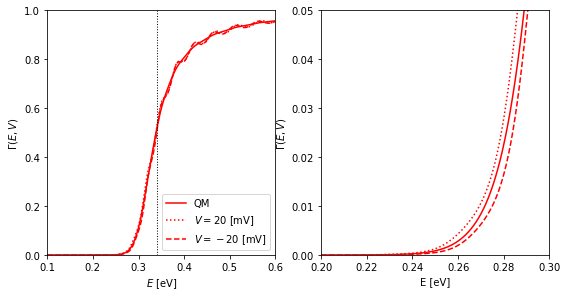

In [95]:
figwidth = 3
figheight = 3
fig, (ax1, ax2) = plt.subplots(1,2)
ax1.plot(E_array, T_QM[:,int(len(V_sd)/2)], 'r', label = 'QM')
ax1.plot(E_array, T_QM[:,-1], 'r:', label = '$V=20$ [mV]')
ax1.plot(E_array, T_QM[:,0], 'r--', label = '$V=-20$ [mV]')
#ax1.plot(E_array, T_tunnel, 'b', label = 'tunnel')
#ax1.plot(E_array, T_tunnel[:,-1], 'b:', label = 'V={:.0f} [mV]'.format(V_sd[0]*1E3))
#ax1.plot(E_array, T_tunnel[:,0], 'b--', label = 'V={:.0f} [mV]'.format(V_sd[-1]*1E3))
ax1.axvline(x=U_top, linestyle=':', color='k', linewidth = 1)
ax1.legend()
ax1.set_xlabel('$E$ [eV]')
ax1.set_ylabel('$\Gamma (E,V)$')
ax1.set_ylim(0,1)# 0.01)
ax1.set_xlim(0.1, 0.6) #0.48, 0.52)
#ax1.set_yscale('log')

ax2.plot(E_array, T_QM[:,int(len(V_sd)/2)], 'r', label = 'QM')
ax2.plot(E_array, T_QM[:,-1], 'r:', label = '$V=20$ [mV]'.format(V_sd[0]))
ax2.plot(E_array, T_QM[:,0], 'r--', label = '$V=-20$ [mV]')
#ax2.plot(E_array, T_tunnel, 'b', label = 'tunnel')
#ax2.plot(E_array, T_tunnel[:,-1], 'b:', label = 'V=-20 [mV]')
#ax2.plot(E_array, T_tunnel[:,0], 'b--', label = 'V=20 [mV]')
ax2.set_ylim(0, 0.05)# 0.01)
ax2.set_xlim(0.2, 0.3) #0.48, 0.52)
ax2.set_xlabel('E [eV]')
ax2.set_ylabel('$\Gamma (E,V)$')

fig.set_size_inches(figwidth*3, figheight*1.5)

# Save 


In [97]:

if save_fig==1:
    fig.savefig(savename_fig+'.svg')
    fig.savefig(savename_fig+'.png')

if save_data == 1:
    ###Data
    data = {
        "V_sd": V_sd.tolist(),
        "E": E_array.tolist(),
        "T_QM": T_QM.T.tolist(),
        "T_tunnel": T_tunnel.T.tolist(),

        # #parameters
        "L":L,
        "dE": dE,
        "T_base": T_K,
        "U_top": U_top,
        }
    json.dump(data, open(savename_data, 'w'))